# EventTree Exploratory Data Analysis

This notebook contains EDA for `full_rho.root` data. 

The idea is to read the content of a chunk of the file (compatible with available RAM memory), exploring the available information about:

 - truth 
 - track 
 - cluster 
 
In particular, the idea is to visualize the distributions of the related variables and get an understanding of:

 - what partiles are involved
 - the characteristics of the physics phenomenon under study

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak

# Options for pandas
# pd.options.display.max_columns = 50
# pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format
pd.pandas.set_option('display.max_columns', None)

REPO_PATH = Path().absolute().parent.parent
DATA_PATH = REPO_PATH / "pnet_data/rho_full"

#### check cluster fullHitsTruthIndex vs visibleHitsTruthIndex match

<div class= "alert alert-block alert-info">
    
The two columns are always equal, so the variables contain same information in practice.
    
</div>

In [2]:
events_file = uproot.open(DATA_PATH / "rho_full.root")["EventTree"]
it = 0
for chunk_data in events_file.iterate(step_size="250 MB",
#                                       expressions=
#                                       ["eventNumber",
#                                        "cluster_fullHitsTruthIndex",
#                                        "cluster_visibleHitsTruthIndex"]):#,
    filter_name="/.*(eventNumber|HitsTruthIndex)/"):
    events = ak.to_dataframe(chunk_data).drop_duplicates()
    it+=1
#     print("\n\n", it)
    if any(events.cluster_fullHitsTruthIndex != events.cluster_visibleHitsTruthIndex):
        print(events.head(20))

total_events = events.eventNumber.unique().size
# print(events.eventNumber.unique().size) # 941847 total events

<div class="alert alert-class alert-info">

In total, the file contains **{{total_events}} raw events.**
    
</div>

## Read data and setup

In [3]:
pdgid_map = {
    -213: 'ρ(770)-',
    213: 'ρ(770)+',
    211: 'π+',
    -211: 'π-',
    111: 'π0',
    22: 'γ',
    -11: 'e-',
    11: 'e+'
}

status_map = {1: 'hit', 2: 'decay'}

In [4]:
### RHO_FULL: NEW DATA

events_file = uproot.open(DATA_PATH / "rho_full.root")["EventTree"]
chunk_data, report = next(events_file.iterate(step_size="80 MB", report=True))
# cellgeo_data = uproot.open(DATA_PATH / "cell_geo.root")  # calorimeter geometry information

In [5]:
print(repr(chunk_data))
print(report)
print(f"{chunk_data.nbytes/(1<<30):,.5f} GB")

<Array [{runNumber: 410000, ...}, ..., {...}] type='15131 * {runNumber: int...'>
<Report start=0 stop=15131 source='/home/luca/workspace/luca/PycharmProjects/PointNet_Segmentation/pnet_data/rho_full/rho_full.root:/EventTree;1'>
0.18646 GB


In [6]:
events_file.typenames()

{'runNumber': 'int32_t',
 'eventNumber': 'int64_t',
 'lumiBlock': 'int32_t',
 'coreFlags': 'uint32_t',
 'mcEventNumber': 'int32_t',
 'mcChannelNumber': 'int32_t',
 'mcEventWeight': 'float',
 'nTruthPart': 'int32_t',
 'G4PreCalo_n_EM': 'int32_t',
 'G4PreCalo_E_EM': 'float',
 'G4PreCalo_n_Had': 'int32_t',
 'G4PreCalo_E_Had': 'float',
 'truthVertexX': 'float',
 'truthVertexY': 'float',
 'truthVertexZ': 'float',
 'truthPartPdgId': 'std::vector<int32_t>',
 'truthPartStatus': 'std::vector<int32_t>',
 'truthPartBarcode': 'std::vector<int32_t>',
 'truthPartPt': 'std::vector<float>',
 'truthPartE': 'std::vector<float>',
 'truthPartMass': 'std::vector<float>',
 'truthPartEta': 'std::vector<float>',
 'truthPartPhi': 'std::vector<float>',
 'nTrack': 'int32_t',
 'trackPt': 'std::vector<float>',
 'trackP': 'std::vector<float>',
 'trackMass': 'std::vector<float>',
 'trackEta': 'std::vector<float>',
 'trackPhi': 'std::vector<float>',
 'trackTruthParticleIndex': 'std::vector<int32_t>',
 'trackVisibleCa

<div class="alert alert-block alert-info">
    
Since *rho_full.root* is a huge file (~5GB, almost 1M events), it is more convenient to process it in chunks.
    
To do this we can use uproot's `.iterate()` method. This takes an argument `step_size` that can be specified both in terms of **number of events** or **chunk memory size**.
    
    **Notes** 
    
     - events are roughly 5 kB each --> 50 MB chunk corresponds to ~50k events
    
     - specified chunk size in memory result in roughly its double (from `nbytes` attribute).
    
</div>

We have 124 branches (keys) per event. 250 MB `step_size` corresponds to nearly 50k events (out of 940k total events).

In [7]:
starting_events = np.unique(chunk_data.eventNumber)
len(starting_events)

15131

<div class="alert alert-block alert-success">
    
It seems the *iterate report* number of events does not match *`unique(eventNumber)` entries*: **47284 VS 36551**
    
This happens because of the ak.to_dataframe does 'inner' merge by default --> fixed by specifying `how='outer'`

    However, that creates a huge amounts of records where generated events do not have hits in the detectors. Hence a more convenient option is to go for inner merge for the moment.
    
**Logbook**
    
- use `step_size="80 MB"` with **left join**
- use `step_size="250 MB"` with inner join
- use `step_size="70 MB"` with outer join
<div>

In [8]:
### OLD
# events_file = uproot.open(DATA_PATH / "rho_full.root")["EventTree"]
# chunk_data, report = next(events_file.iterate(step_size="80 MB", report=True))

### NEW
events_file = uproot.open(DATA_PATH / "rho_full.root")
chunk_data, report = next(events_file["EventTree"].iterate(step_size="80 MB", report=True, library="pd"))
chunk_data.head(10)

runNumber  eventNumber  lumiBlock  coreFlags  mcEventNumber  \
0     410000         2001          1          0           2001   
1     410000         2006          1          0           2006   
2     410000         2009          1          0           2009   
3     410000         2010          1          0           2010   
4     410000         2012          1          0           2012   
5     410000         2002          1          0           2002   
6     410000         2013          1          0           2013   
7     410000         2005          1          0           2005   
8     410000         2004          1          0           2004   
9     410000         2003          1          0           2003   

   mcChannelNumber  mcEventWeight  nTruthPart  G4PreCalo_n_EM  G4PreCalo_E_EM  \
0           900148         1.0000           5               4          1.0529   
1           900148         1.0000           5               2          3.4321   
2           900148         1.0000           5               6         13.0795   
3           900148         1.0000           5               6          7.2223   
4           900148         1.0000           5               0          0.0000   
5           900148         1.0000           5              23        189.7836   
6           900148         1.0000           5               1          2.3120   
7           900148         1.0000           5               0          0.0000   
8           900148         1.0000           5               0          0.0000   
9           900148         1.0000           5               0          0.0000   

   G4PreCalo_n_Had  G4PreCalo_E_Had  truthVertexX  truthVertexY  truthVertexZ  \
0                8           3.1165       -0.5005       -0.4795       -5.3865   
1                0           0.0000       -0.5042       -0.4894      -13.9020   
2                0           0.0000       -0.4996       -0.4825      -10.8549   
3                1          25.4773       -0.5038       -0.4925       22.7470   
4                0           0.0000       -0.5139       -0.5109      -22.4613   
5                6           8.4221       -0.4872       -0.5050       31.5281   
6                1          64.5837       -0.4947       -0.5049       55.3017   
7                0           0.0000       -0.5037       -0.5038       29.6683   
8                0           0.0000       -0.4949       -0.4962       -0.3772   
9                0           0.0000       -0.4938       -0.4985       18.0959   

          truthPartPdgId  truthPartStatus  truthPartBarcode  \
0    [213 211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
1  [-213 -211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
2    [213 211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
3  [-213 -211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
4  [-213 -211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
5  [-213 -211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
6    [213 211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
7    [213 211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
8  [-213 -211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   
9    [213 211 111 22 22]      [2 1 2 1 1]       [1 2 3 4 5]   

                                         truthPartPt  \
0  [2.571387767791748 3.1658856868743896 0.633602...   
1  [5.021877765655518 1.5745843648910522 3.812004...   
2  [30.200136184692383 22.07258415222168 8.259051...   
3  [19.063579559326172 10.347452163696289 8.71619...   
4  [1.3169068098068237 0.30493831634521484 1.1871...   
5  [88.79397583007812 6.925630569458008 81.875099...   
6  [17.226943969726562 16.348827362060547 1.04675...   
7  [91.9850082397461 35.78236770629883 56.2093276...   
8  [11.17548656463623 1.8504470586776733 9.829389...   
9  [318.5910339355469 67.81613159179688 250.77510...   

                                          truthPartE  \
0  [6.746258735656738 5.534257411956787 1.2120015...   
1  [14.617471694946289 5.083908557891846 9.533563...   
2  [75.471153

### Checks `nTruthPart`, `nTrack` and `nCluster`

In [9]:
to_check_particles = chunk_data.nTruthPart != chunk_data.truthPartPt.apply(lambda x:len(x))
to_check_tracks = chunk_data.nTrack != chunk_data.trackPt.apply(lambda x:len(x))
to_check_clusters = chunk_data.nCluster != chunk_data.cluster_E.apply(lambda x:len(x))


print(f"The following quantities present unexpected content:\n\n{to_check_particles.sum()=}\n{to_check_tracks.sum()=}\n{to_check_clusters.sum()=}")

The following quantities present unexpected content:

to_check_particles.sum()=0
to_check_tracks.sum()=1
to_check_clusters.sum()=0


In [10]:
chunk_data[chunk_data.nTrack != chunk_data.trackPt.apply(lambda x:len(x))]

runNumber  eventNumber  lumiBlock  coreFlags  mcEventNumber  \
8545     410000       257338       3001          0         257338   

      mcChannelNumber  mcEventWeight  nTruthPart  G4PreCalo_n_EM  \
8545           900148         1.0000           6               4   

      G4PreCalo_E_EM  G4PreCalo_n_Had  G4PreCalo_E_Had  truthVertexX  \
8545         18.3883                0           0.0000       -0.5027   

      truthVertexY  truthVertexZ             truthPartPdgId  truthPartStatus  \
8545       -0.4847       -9.0231  [-213 -211 111 -11 11 22]    [2 1 2 1 1 1]   

      truthPartBarcode                                        truthPartPt  \
8545     [1 2 3 4 5 6]  [45.885990142822266 19.832744598388672 26.1066...   

                                             truthPartE  \
8545  [47.88125228881836 21.187259674072266 26.69399...   

                                          truthPartMass  \
8545  [4.191603183746338 0.1395701766014099 0.134976...   

                                           truthPartEta  \
8545  [-0.2800711691379547 -0.36745280027389526 -0.2...   

                                           truthPartPhi  nTrack  \
8545  [2.9826369285583496 3.0379581451416016 2.94061...       2   

                                                trackPt  \
8545  [19.904390335083008 7.546391487121582 0.514886...   

                                                 trackP  \
8545  [21.261037826538086 7.7092719078063965 0.52551...   

                                              trackMass  \
8545  [0.13956999778747559 0.13956999778747559 0.139...   

                                               trackEta  \
8545  [-0.36714503169059753 -0.20739628374576569 -0....   

                                               trackPhi  \
8545  [3.0378050804138184 2.946349859237671 2.953226...   

      trackTruthParticleIndex                 trackVisibleCalHitCaloEnergy  \
8545                  [1 3 4]  [13.138012886047363 10.584362030029297 0.0]   

                        trackFullCalHitCaloEnergy  trackSubtractedCaloEnergy  \
8545  [15.858463287353516 10.646174430847168 0.0]       [13199.0 5209.0 0.0]   

      trackNumberOfPixelHits  trackNumberOfSCTHits  \
8545                 [4 4 5]               [8 8 6]   

      trackNumberOfPixelDeadSensors  trackNumberOfSCTDeadSensors  \
8545                        [0 0 0]                      [0 0 0]   

      trackNumberOfPixelSharedHits  trackNumberOfSCTSharedHits  \
8545                       [0 0 0]                     [0 0 0]   

      trackNumberOfPixelHoles  trackNumberOfSCTHoles  \
8545                  [0 0 0]                [0 0 0]   

      trackNumberOfInnermostPixelLayerHits  \
8545                               [1 1 1]   

      trackNumberOfNextToInnermostPixelLayerHits  \
8545                                     [1 1 2]   

      trackExpectInnermostPixelLayerHit  \
8545                            [1 1 1]   

      trackExpectNextToInnermostPixelLayerHit  trackNumberOfTRTHits  \
8545                                  [1 1 1]             [31 32 0]   

      trackNumberOfTRTOutliers  \
8545                   [0 0 0]   

                                        trackChiSquared  trackNumberDOF  \
8545  [37.69770431518555 33.183650970458984 24.46737...      [42 43 11]   

                                                trackD0  \
8545  [-0.00442121597006917 0.0012219498166814446 -0...   

                                                trackZ0  \
8545  [-9.068134307861328 -8.981307983398438 -9.1527...   

                            trackEta_PreSamplerB  \
8545  [-0.3730625808238983 -0.21346904337406158]   

                        trackPhi_PreSamplerB           trackEta_PreSamplerE  \
8545  [3.0590381622314453 2.890777111053467]  [-1000000000.0 -1000000000.0]   

               trackPhi_PreSamplerE  \
8545  [-1000000000.0 -1000000000.0]   

                                    trackEta_EMB1  \
8545  [-0.37271007895469666 -0.21310022473335266]   

                               track

## EventTree inspection

In [11]:
import awkward as ak

selected_cols = [
    #  'runNumber', # always fixed
    'eventNumber',
    #  'lumiBlock', # not interesting?
    #  'coreFlags', # always fixed
    #  'mcEventNumber', # not interesting?
    #  'mcChannelNumber', # always fixed
    #  'mcEventWeight', # always fixed
    'nTruthPart',
    #  'G4PreCalo_n_EM', # not interesting?
    #  'G4PreCalo_E_EM', # not interesting?
    #  'G4PreCalo_n_Had', # not interesting?
    #  'G4PreCalo_E_Had', # not interesting?
    #  'truthVertexX', # very narrow distribution: sigma<10e-2
    #  'truthVertexY', # very narrow distribution: sigma<10e-2
    #  'truthVertexZ', # very narrow distribution: sigma~0.36
    'truthPartPdgId',
    'truthPartStatus',
    #  'truthPartBarcode', # not interesting? --> it has multiple list values though
    'truthPartPt',
    'truthPartE',
    'truthPartMass',
    'truthPartEta',
    'truthPartPhi',
    'nTrack',
    'trackPt',
    'trackP',
    'trackMass',
    'trackEta',
    'trackPhi',
    'trackTruthParticleIndex',
    'trackVisibleCalHitCaloEnergy',  # not interesting?
    'trackFullCalHitCaloEnergy',  # not interesting?
    'trackSubtractedCaloEnergy',  # not interesting?
    #  'trackNumberOfPixelHits', # not interesting?
    #  'trackNumberOfSCTHits', # not interesting?
    #  'trackNumberOfPixelDeadSensors', # not interesting?
    #  'trackNumberOfSCTDeadSensors', # not interesting?
    #  'trackNumberOfPixelSharedHits', # not interesting?
    #  'trackNumberOfSCTSharedHits', # not interesting?
    #  'trackNumberOfPixelHoles', # not interesting?
    #  'trackNumberOfSCTHoles', # not interesting?
    #  'trackNumberOfInnermostPixelLayerHits', # not interesting?
    #  'trackNumberOfNextToInnermostPixelLayerHits', # not interesting?
    #  'trackExpectInnermostPixelLayerHit', # not interesting?
    #  'trackExpectNextToInnermostPixelLayerHit', # not interesting?
    #  'trackNumberOfTRTHits', # not interesting?
    #  'trackNumberOfTRTOutliers', # not interesting?
    #  'trackChiSquared', # not interesting?
    #  'trackNumberDOF', # not interesting?
    'trackD0',
    'trackZ0',
    #  'trackEta_PreSamplerB',
    #  'trackPhi_PreSamplerB',
    #  'trackEta_PreSamplerE',
    #  'trackPhi_PreSamplerE',
    #  'trackEta_EMB1',
    #  'trackPhi_EMB1',
    #  'trackEta_EMB2',
    #  'trackPhi_EMB2',
    #  'trackEta_EMB3',
    #  'trackPhi_EMB3',
    #  'trackEta_EME1',
    #  'trackPhi_EME1',
    #  'trackEta_EME2',
    #  'trackPhi_EME2',
    #  'trackEta_EME3',
    #  'trackPhi_EME3',
    #  'trackEta_HEC0',
    #  'trackPhi_HEC0',
    #  'trackEta_HEC1',
    #  'trackPhi_HEC1',
    #  'trackEta_HEC2',
    #  'trackPhi_HEC2',
    #  'trackEta_HEC3',
    #  'trackPhi_HEC3',
    #  'trackEta_TileBar0',
    #  'trackPhi_TileBar0',
    #  'trackEta_TileBar1',
    #  'trackPhi_TileBar1',
    #  'trackEta_TileBar2',
    #  'trackPhi_TileBar2',
    #  'trackEta_TileGap1',
    #  'trackPhi_TileGap1',
    #  'trackEta_TileGap2',
    #  'trackPhi_TileGap2',
    #  'trackEta_TileGap3',
    #  'trackPhi_TileGap3',
    #  'trackEta_TileExt0',
    #  'trackPhi_TileExt0',
    #  'trackEta_TileExt1',
    #  'trackPhi_TileExt1',
    #  'trackEta_TileExt2',
    #  'trackPhi_TileExt2',
    'nCluster',
    'cluster_E',
    'cluster_E_LCCalib',
    'cluster_Pt',
    'cluster_Eta',
    'cluster_Phi',
    'cluster_nCells',
    #     'cluster_ENG_CALIB_TOT', # always -1
    #     'cluster_ENG_CALIB_OUT_T', # always -1
    #     'cluster_ENG_CALIB_DEAD_TOT', # always -1
    'cluster_EM_PROBABILITY',
    #  'cluster_HAD_WEIGHT', # not interesting?
    #  'cluster_OOC_WEIGHT', # not interesting?
    #  'cluster_DM_WEIGHT', # not interesting?
    #  'cluster_CENTER_MAG', # not interesting?
    #  'cluster_FIRST_ENG_DENS', # not interesting?
    #  'cluster_CENTER_LAMBDA', # not interesting?
    #  'cluster_ISOLATION', # not interesting?
    #  'cluster_ENERGY_DigiHSTruth', # not interesting?
    'cluster_cell_ID',
    'cluster_cell_E',
    'cluster_cell_hitsE_EM',
    'cluster_cell_hitsE_nonEM',
    'cluster_cell_hitsE_Invisible',
    'cluster_cell_hitsE_Escaped',
    'cluster_fullHitsTruthIndex',
    'cluster_fullHitsTruthE',
    'cluster_visibleHitsTruthIndex', # same as fullHitsTruthIndex
    'cluster_visibleHitsTruthE',
    'cluster_cell_hitsTruthIndex',
    'cluster_cell_hitsTruthE'
]

events = ak.to_dataframe(next(events_file["EventTree"].iterate(step_size="80 MB")), how='left')[selected_cols] # exploded
# events = chunk_data[selected_cols] # un-exploded

# print(f"The un-exploded{events.shape}")



The un-exploded, nested dataset contains {{events.shape[0]}} rows and the selected {{events.shape[1]}} columns.

In [12]:
converted_events = events.eventNumber.unique()

# set(converted_events).difference(starting_events)
print("Missed events due to conversion:\n\n")
print(set(starting_events).difference(converted_events))

Missed events due to conversion:


set()


### Check join output

In [13]:
events.isna().sum()

eventNumber                            0
nTruthPart                             0
truthPartPdgId                         0
truthPartStatus                        0
truthPartPt                            0
truthPartE                             0
truthPartMass                          0
truthPartEta                           0
truthPartPhi                           0
nTrack                                 0
trackPt                          1903194
trackP                           1903194
trackMass                        1903194
trackEta                         1903194
trackPhi                         1903194
trackTruthParticleIndex          1903194
trackVisibleCalHitCaloEnergy     1903194
trackFullCalHitCaloEnergy        1903194
trackSubtractedCaloEnergy        1903194
trackD0                          1903194
trackZ0                          1903194
nCluster                               0
cluster_E                          38656
cluster_E_LCCalib                  38656
cluster_Pt      

In [14]:
events[events.eventNumber.isna()]

,,,,eventNumber,nTruthPart,truthPartPdgId,truthPartStatus,truthPartPt,truthPartE,truthPartMass,truthPartEta,truthPartPhi,nTrack,trackPt,trackP,trackMass,trackEta,trackPhi,trackTruthParticleIndex,trackVisibleCalHitCaloEnergy,trackFullCalHitCaloEnergy,trackSubtractedCaloEnergy,trackD0,trackZ0,nCluster,cluster_E,cluster_E_LCCalib,cluster_Pt,cluster_Eta,cluster_Phi,cluster_nCells,cluster_EM_PROBABILITY,cluster_cell_ID,cluster_cell_E,cluster_cell_hitsE_EM,cluster_cell_hitsE_nonEM,cluster_cell_hitsE_Invisible,cluster_cell_hitsE_Escaped,cluster_fullHitsTruthIndex,cluster_fullHitsTruthE,cluster_visibleHitsTruthIndex,cluster_visibleHitsTruthE,cluster_cell_hitsTruthIndex,cluster_cell_hitsTruthE
entry,subentry,subsubentry,subsubsubentry,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


<div class="alert alert-block alert-info">
    
The number of *full** unique events is **{{events.eventNumber.unique().size}}**.
    
    
\* here refers to events with matching track and cluster information
</div>

In [15]:
events.head(10)

eventNumber  nTruthPart  \
entry subentry subsubentry subsubsubentry                            
0     0        0           0                      2001           5   
               1           0                      2001           5   
               2           0                      2001           5   
               3           0                      2001           5   
               4           0                      2001           5   
               5           0                      2001           5   
               6           0                      2001           5   
      1        NaN         NaN                    2001           5   
      2        NaN         NaN                    2001           5   
      3        NaN         NaN                    2001           5   

                                           truthPartPdgId  truthPartStatus  \
entry subentry subsubentry subsubsubentry                                    
0     0        0           0                          213                2   
               1           0                          213                2   
               2           0                          213                2   
               3           0                          213                2   
               4           0                          213                2   
               5           0                          213                2   
               6           0                          213                2   
      1        NaN         NaN                        211                1   
      2        NaN         NaN                        111                2   
      3        NaN         NaN                         22                1   

                                           truthPartPt  truthPartE  \
entry subentry subsubentry subsubsubentry                            
0     0        0           0                    2.5714      6.7463   
               1           0                    2.5714      6.7463   
               2           0                    2.5714      6.7463   
               3           0                    2.5714      6.7463   
               4           0                    2.5714      6.7463   
               5           0                    2.5714      6.7463   
               6           0                    2.5714      6.7463   
      1        NaN         NaN                  3.1659      5.5343   
      2        NaN         NaN                  0.6336      1.2120   
      3        NaN         NaN                  0.4507      0.7611   

                                           truthPartMass  truthPartEta  \
entry subentry subsubentry subsubsubentry                                
0     0        0           0                      2.8231        1.5142   
               1           0                      2.8231        1.5142   
               2           0                      2.8231        1.5142   
               3           0                      2.8231        1.5142   
               4           0                      2.8231        1.5142   
               5           0                      2.8231        1.5142   
               6           0                      2.8231        1.5142   
      1        NaN         NaN                    0.1396        1.1571   
      2        NaN         NaN                    0.1350        1.2578   
      3        NaN         NaN                   -0.0000        1.1150   

                                           truthPartPhi  nTrack  trackPt  \
entry subentry subsubentry subsubsubentry                                  
0     0        0           0                     2.5839       0      NaN   
               1           0                     2.5839       0      NaN   
               2           0                     2.5839       0      NaN   
               3           0                     2.5839       0      NaN   
               4           0                     2.5839       0      NaN   
   

### data keys

In [16]:
events.iloc[:100].to_csv("results/check_EventTree_index.csv")

<div class="alert alert-block alert-warning">

Given the above dataframe "exploded" by awkward, the natural question is **what are the keys of the table?**

The index report **4 levels**, so we can try to guess based on physics knowledge behind the simulation of the data:
    
**initial guess**
    
{
    
    "level1": "eventNumber",  # OK: id event
    "level2": "truthPartPdgId",  # OK id true generated particle
    "level3": "",  # id track?
    "level4": "",  # id cluster?
}
    
**By looking at the values, however, it seems the 3rd and 4th levels are related to cluster hits and cluster cell hits instead.**
    
    
    CHECK THIS WITH IACOPO/MAX!!!
    
</div>

In [17]:
# guess from data values
data_keys = {
    "level1": "eventNumber",  # OK: id event
    "level2": "truthPartPdgId",  # OK id true generated particle
    #     "level3": ["cluster_fullHitsTruthIndex", "cluster_visibleHitsTruthIndex"],  # id cluster hits?
    "level3": "cluster_fullHitsTruthIndex",  # id cluster hits?
    "level4": "cluster_cell_hitsTruthIndex",  # id cluster cell hits?
}

In [18]:
events.set_index(list(data_keys.values()), inplace=True)
events.head(20)

nTruthPart  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex               
2001         213           1.0000                     1.0000                                5   
                           NaN                        1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
             211           NaN                        NaN                                   5   
             111           NaN                        NaN                                   5   
             22            NaN                        NaN                                   5   
                                                      NaN                                   5   
2006        -213           3.0000                     3.0000                                5   
                           4.0000                     3.0000                                5   
                           NaN                        3.0000                                5   
                                                      3.0000                                5   
                                                      4.0000                                5   
                                                      3.0000                                5   
                                                      3.0000                                5   
                                                      3.0000                                5   
                                                      3.0000                                5   

                                                                                   truthPartStatus  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex                    
2001         213           1.0000                     1.0000                                     2   
                           NaN                        1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
             211           NaN                        NaN                                        1   
             111           NaN                        NaN                                        2   
             22            NaN                        NaN                                        1   
                                                      NaN                                        1   
2006        -213           3.0000                     3.0000                                     2   
                           4.0000                     3.0000                                     2   
                           NaN                        3.0000                                     2   
                                                      3.0000                                     2   
                                                      4.0000                                     2   
                                                      3.0000                                     2   
          

### eventNumber, nTruthPart, nTrack, nCluster distributions

In [19]:
def explore_vars_distribution(events_df, analysis_cols, plot_type):
    events_ = events_df.reset_index()

    # unique values
    unique_vals = {k: None for k in analysis_cols}
    for c in analysis_cols:
        unique_vals[c] = np.sort(events_[c].unique())
        print(f"{c} has {len(unique_vals[c])} unique values:\n",
              unique_vals[c])

    
    # distribution summary (only numeric variables)
    if plot_type=="hist":
        summary = events_[analysis_cols].describe(percentiles=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])
    elif plot_type=="bar":
        summary=None
    
    # plots
    fig, axes = plt.subplots(1,
                             len(analysis_cols),
                             figsize=(4 * len(analysis_cols), 4),
#                              sharey=True
                            )
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
        
    for c, ax in zip(analysis_cols, axes):
        if plot_type == "hist":
            events_[c].plot(kind=plot_type, ax=ax, log=True)
            ax.set_title(c)
            ax.grid()
            ax.grid(which="minor", alpha=0.3)
        elif plot_type == "bar":
            events_[c] = pd.Categorical(events_[c], categories=np.sort(events_[c].unique()), ordered=True)
            events_.drop_duplicates(["eventNumber", c])[c].value_counts(sort=False).plot(kind="bar", log=True, ax=ax) 
            ax.yaxis.grid()
            ax.yaxis.grid(which="minor", alpha=0.3)
    plt.show()
    return summary, unique_vals    


def mosaic_plot(mosaic_df, analysis_cols):
#     mosaic_df_ = events.reset_index().set_index("eventNumber")[analysis_cols]
    ct_margins = pd.crosstab(mosaic_df_[analysis_cols[0]],
                             mosaic_df_[analysis_cols[1]],
                             margins=True)

    plt.figure(figsize=(8, 6))
    plt.imshow(ct_margins,
               cmap='coolwarm',
               interpolation='nearest',
               aspect="auto")

    # Add annotations
    for i in range(len(ct_margins)):
        for j in range(len(ct_margins.columns)):
            plt.text(j,
                     i,
                     ct_margins.iloc[i, j],
                     ha='center',
                     va='center',
                     color='white')

    # Add axis labels
    plt.xticks(range(len(ct_margins.columns)), ct_margins.columns)
    plt.yticks(range(len(ct_margins)), ct_margins.index)

    # Add color bar
    plt.colorbar()

    # Add title and labels
    plt.title(f'{analysis_cols[0]} VS {analysis_cols[1]}')
    plt.xlabel(f'{analysis_cols[1]}')
    plt.ylabel(f'{analysis_cols[0]}')

    # Show the plot
    plt.show()

nTruthPart has 5 unique values:
 [3 5 6 7 8]
nTrack has 16 unique values:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 18]
nCluster has 27 unique values:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 28]


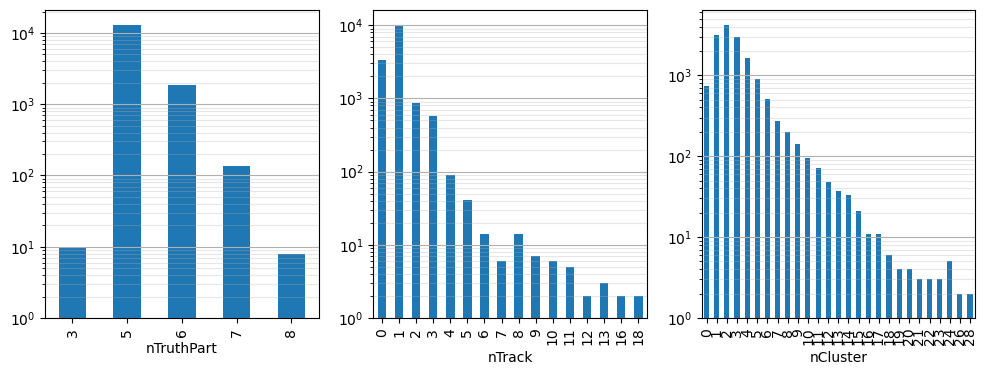

In [20]:
analysis_cols = ["nTruthPart", "nTrack", "nCluster"]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="bar")
sms

nTruthPart has 5 unique values:
 [3 5 6 7 8]
nTrack has 16 unique values:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 16 18]
nCluster has 27 unique values:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 28]


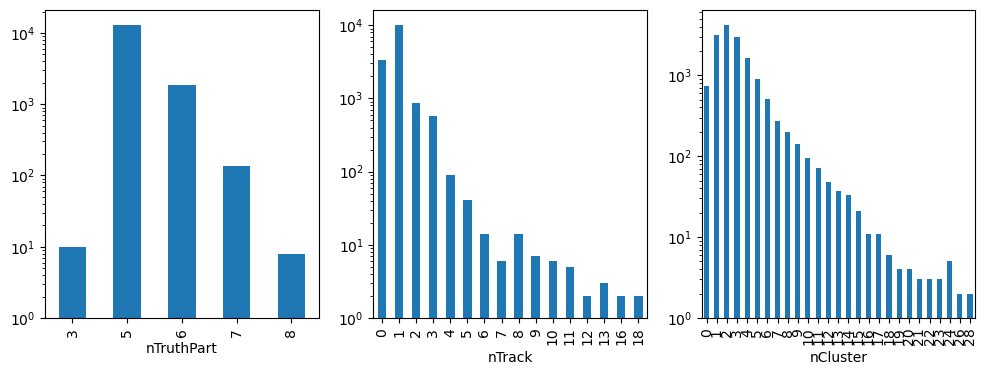

In [21]:
analysis_cols = ["nTruthPart", "nTrack", "nCluster"]


fig, axes = plt.subplots(1, len(analysis_cols), figsize=(12,4))
events_ = events.reset_index()

# UNIQUE_VALS
unique_vals = {k: None for k in analysis_cols}
for c in analysis_cols:
    unique_vals[c] = np.sort(events_[c].unique())
    print(f"{c} has {len(unique_vals[c])} unique values:\n",
          unique_vals[c])


for c, ax in zip(analysis_cols, axes):
    events_[c] = pd.Categorical(events_[c], categories=np.sort(events_[c].unique()), ordered=True)
    events_.drop_duplicates(["eventNumber", c])[c].value_counts(sort=False).plot(kind="bar", log=True, ax=ax)
# events.reset_index().drop_duplicates(["eventNumber", "truthPartPdgId"]).truthPartPdgId.value_counts().plot(kind="bar", log=True)

<div class="alert alert-block alert-info"> <b>NOTE</b> 

`{{list(unique_vals.keys())[0]}}` ranges from {{unique_vals[list(unique_vals.keys())[0]][0]}} to {{unique_vals[list(unique_vals.keys())[0]][-1]}} generated particles.
    
`{{list(unique_vals.keys())[1]}}` has an exponential decay, with almost 90% of events having just 1 track.
The tail, however is long, extending up to {{unique_vals[list(unique_vals.keys())[1]][-1]}}.
    
    
`{{list(unique_vals.keys())[1]}}` has an exponential decay, with a variable number of clusters per event as expected. This ranges from {{unique_vals[list(unique_vals.keys())[2]][0]}} to {{unique_vals[list(unique_vals.keys())[2]][-1]}}.

    
    
</div>


### pdgId, status

In [22]:
bool_mask = events.reset_index().groupby("eventNumber")[[
    "truthPartPdgId"
]].agg(lambda x: len(np.unique(x))) > 1

multiparticle_event_id = bool_mask[bool_mask.truthPartPdgId ==
                                   True].index.values

events.loc[multiparticle_event_id]

nTruthPart  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex               
2001         213           1.0000                     1.0000                                5   
                           NaN                        1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
...                                                                                       ...   
654420      -213           NaN                        1.0000                                5   
            -211           NaN                        NaN                                   5   
             111           NaN                        NaN                                   5   
             22            NaN                        NaN                                   5   
                                                      NaN                                   5   

                                                                                   truthPartStatus  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex                    
2001         213           1.0000                     1.0000                                     2   
                           NaN                        1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
...                                                                                            ...   
654420      -213           NaN                        1.0000                                     2   
            -211           NaN                        NaN                                        1   
             111           NaN                        NaN                                        2   
             22            NaN                        NaN                                        1   
                                                      NaN                                        1   

                                                                                   truthPartPt  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex                
2001         213           1.0000                     1.0000                            2.5714   
                           NaN                        1.0000                            2.5714   
                                                      1.0000                            2.5714   
                                                      1.0000                            2.5714   
                                                      1.0000                            2.5714   
...                                                                                        ...   
654420      -213           NaN                        1.0000                           49.0390   
            -211           NaN                        NaN                              31.0870   
             111           NaN                        NaN                              17.9564   
             22            NaN                        NaN                              16.7433   
                                                      NaN                               1.2132   

                                                                                   truthPartE  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex               
2001         213         

truthPartPdgId has 8 unique values:
 [-213 -211  -11   11   22  111  211  213]
truthPartStatus has 2 unique values:
 [1 2]


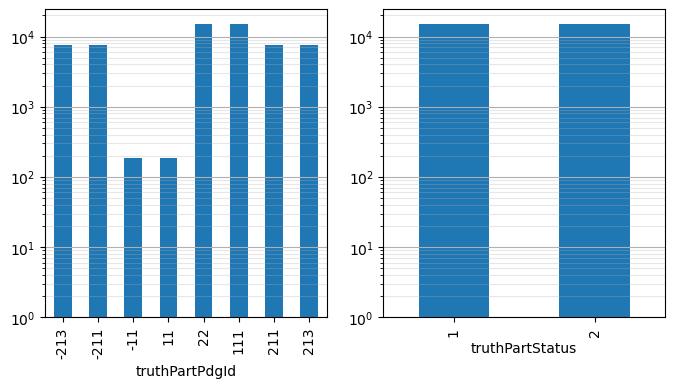

In [23]:
analysis_cols = ["truthPartPdgId", "truthPartStatus"]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="bar")
sms

<div class="alert alert-block alert-info"> <b>NOTE</b> 

    
Notice that we have {{len(multiparticle_event_id)}} events, where the generated particles where more than one.
    
</div>

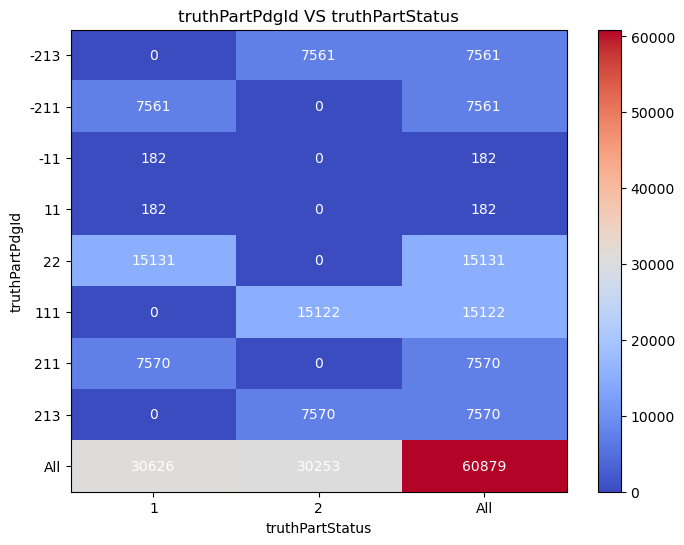

In [24]:
mosaic_df_ = events.reset_index().drop_duplicates(["eventNumber", analysis_cols[0]])[analysis_cols]

mosaic_plot(mosaic_df_, analysis_cols)

<div class="alert alert-block alert-info">
    
`{{analysis_cols[0]}}` values present the following mapping:

    {{_ = [print(f"{k}:\t{v}") for k, v in pdgid_map.items()]}}
    

`{{analysis_cols[1]}}` values present the following mapping:
    
    {{_ = [print(f"{k}:\t{v}") for k, v in status_map.items()]}}
    
    
**Note that rho and pi0 particles never hit the detector but decay before. Hence, what we observe are charged pions, photons and electrons.**
</div>

### pdgId, mass

In [25]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# _ = events.reset_index().drop_duplicates(["eventNumber", "truthPartPdgId"])[
#     ["truthPartPdgId", "truthPartMass"]
# ].hist("truthPartMass", by="truthPartPdgId", ax=ax, log=True, bins=100)

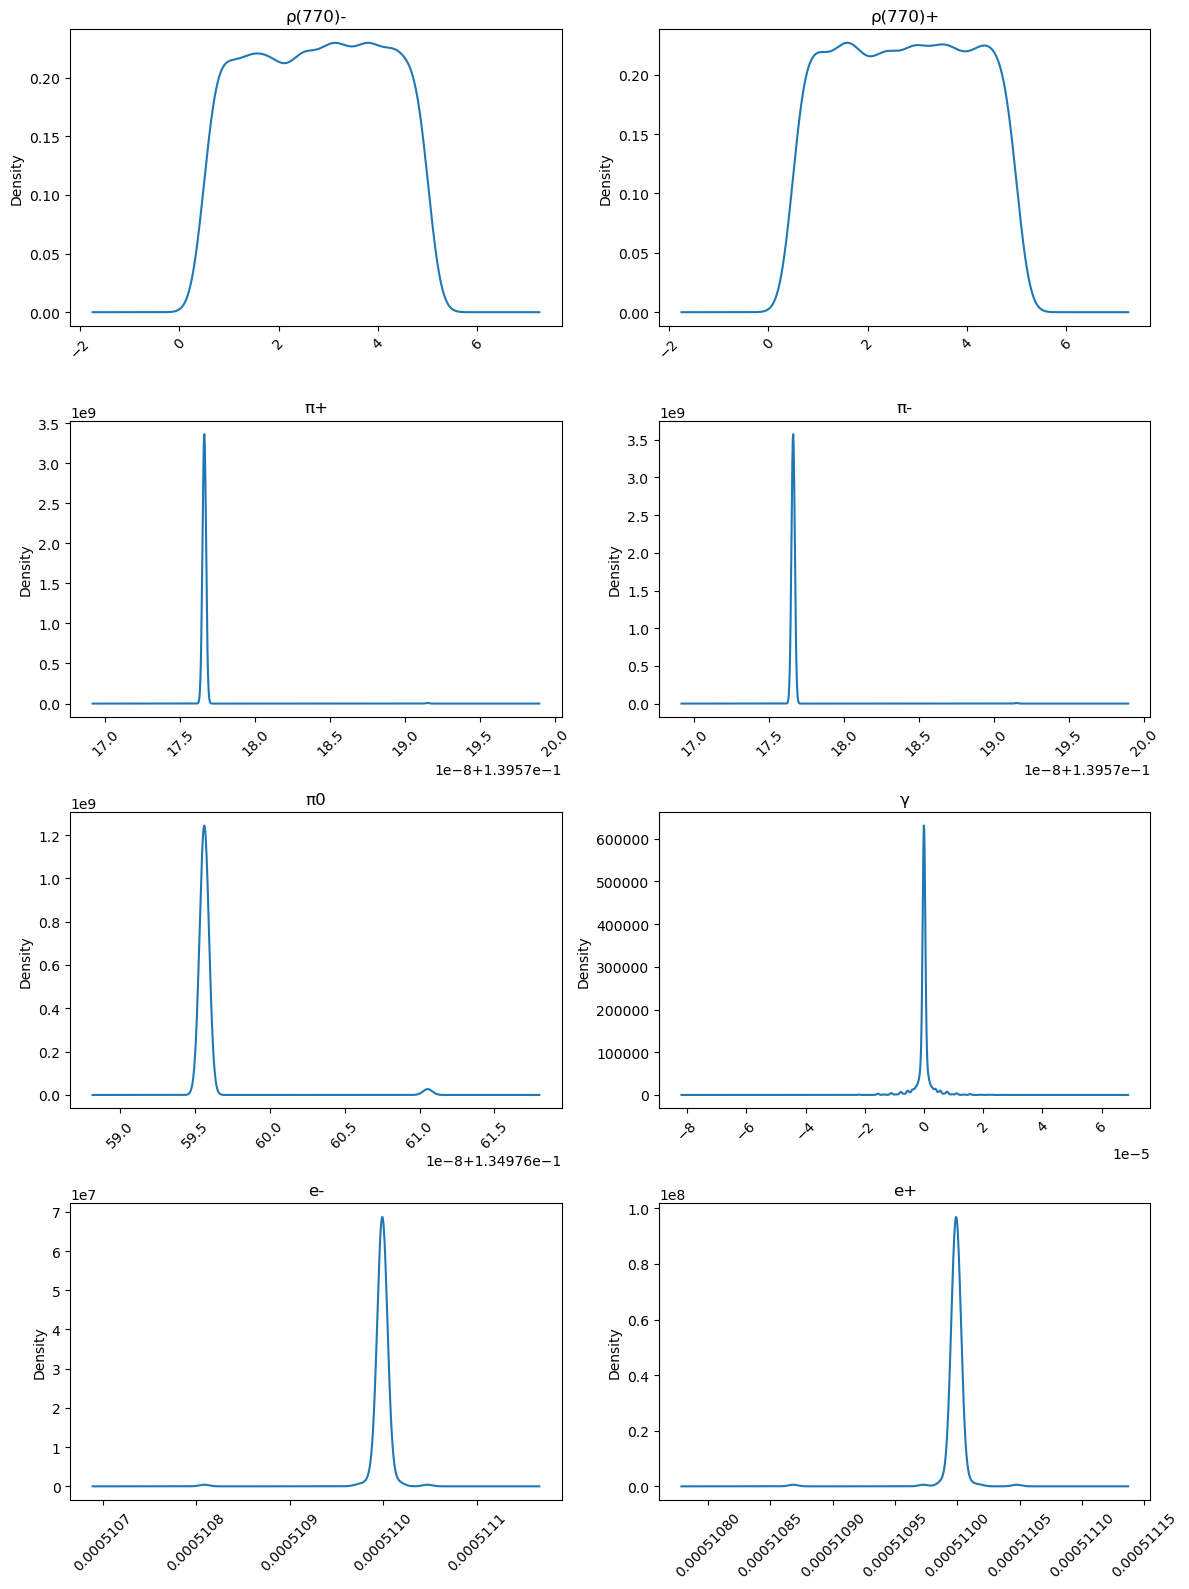

In [26]:
fig, axes = plt.subplots(4,2, figsize=(12, 16))
axes = axes.flatten()

pidVSmass_df = events.reset_index().drop_duplicates(["eventNumber", "truthPartPdgId"])[
    ["truthPartPdgId", "truthPartMass"]
]
for pid, ax in zip(pdgid_map.items(), axes):
    hist_ = pidVSmass_df.query("truthPartPdgId==@pid[0]").truthPartMass.plot(kind="kde", ax=ax, rot=45)
#     hist_ = pidVSmass_df.query("truthPartPdgId==@pid[0]").truthPartMass.plot(kind="hist", ax=ax, rot=45, density=True, log=True)    
    ax.set_title(pid[1])
fig.tight_layout() 

<div class="alert alert-block alert-info">
    
Rho are generated with uniform mass in the range $[0-5]$.
    
Pi+-0 instead have only two unique values, very close to each other ($<$10e-7). This suggests a unique value of 0.1396 up to approximation.
    
Gamma have a narrow distribution around 0 (sigma in the order of 10e-5).
    
Electrons have mostly one peak around 5.11 e-4.
    
    
                                                                              
</div>

### truth quantities

#### Energy and Momentum

truthPartPt has 77781 unique values:
 [4.8407891e-08 5.6656184e-08 6.6058767e-08 ... 1.9340548e+03 1.9435184e+03
 1.9554602e+03]
truthPartE has 77767 unique values:
 [7.9553821e-08 9.5835652e-08 1.4858252e-07 ... 1.9973246e+03 1.9985042e+03
 1.9991769e+03]


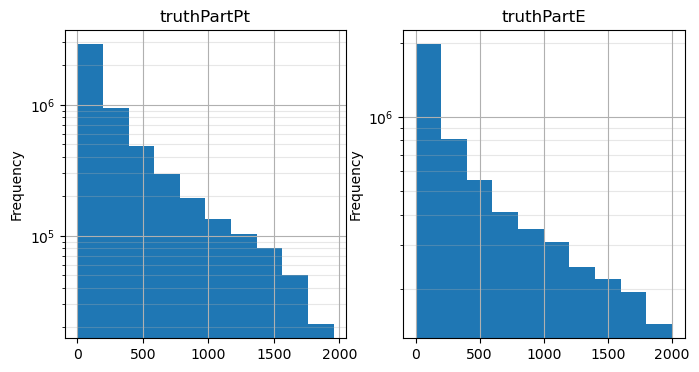

,truthPartPt,truthPartE
count,"5,198,891.0000","5,198,891.0000"
mean,302.2726,545.2186
std,371.6650,537.6379
min,0.0000,0.0000
0%,0.0000,0.0000
...,...,...
50%,155.4531,348.3175
75%,409.9276,879.5396
90%,847.5821,"1,429.4526"
100%,"1,955.4602","1,999.1769"


In [27]:
analysis_cols = [
    "truthPartPt",
    "truthPartE",
]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="hist")
sms

#### Angular distributions

truthPartEta has 77761 unique values:
 [-5.3187094 -5.2539315 -5.2310724 ...  5.144262   5.465787   5.503069 ]
truthPartPhi has 77754 unique values:
 [-3.141519  -3.1414752 -3.141469  ...  3.1415052  3.1415117  3.1415837]


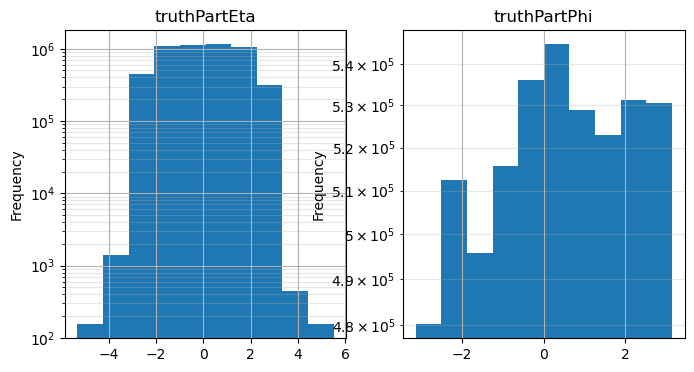

,truthPartEta,truthPartPhi
count,"5,198,891.0000","5,198,891.0000"
mean,0.0244,0.0506
std,1.4741,1.7994
min,-5.3187,-3.1415
0%,-5.3187,-3.1415
...,...,...
50%,0.0221,0.0638
75%,1.2470,1.6053
90%,2.0238,2.5285
100%,5.5031,3.1416


In [28]:
analysis_cols = [
    "truthPartEta",
    "truthPartPhi",
]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="hist")
sms

### track observables

#### Energy, Momentum and Mass

trackPt has 14429 unique values:
 [5.0028455e-01 5.0153458e-01 5.0203341e-01 ... 6.8117836e+04 1.1294505e+06
           nan]
trackP has 14431 unique values:
 [5.0875860e-01 5.1467502e-01 5.1651037e-01 ... 1.7240172e+05 2.0428495e+06
           nan]
trackMass has 2 unique values:
 [0.13957     nan]


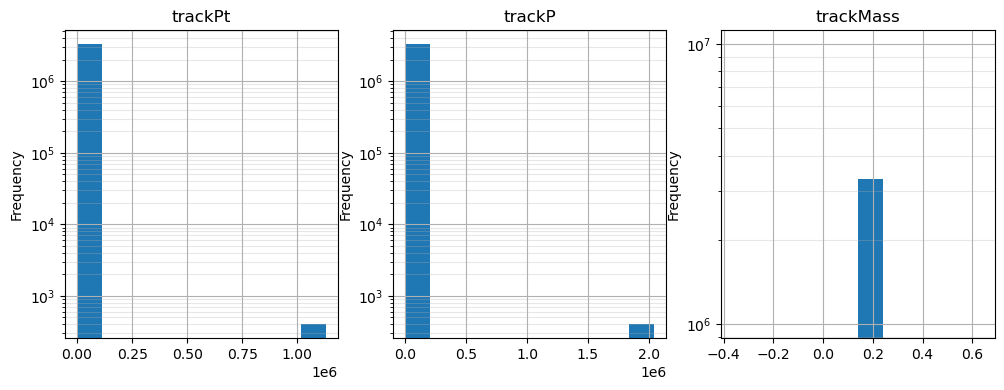

,trackPt,trackP,trackMass
count,"3,295,697.0000","3,295,697.0000","3,295,697.0000"
mean,390.6071,667.1677,0.1396
std,"12,580.8525","22,791.4004",0.0000
min,0.5003,0.5088,0.1396
0%,0.5003,0.5088,0.1396
...,...,...,...
50%,73.6420,141.8010,0.1396
75%,223.3651,406.1341,0.1396
90%,496.1550,812.6667,0.1396
100%,"1,129,450.5000","2,042,849.5000",0.1396


In [29]:
analysis_cols = [
    "trackPt",
    "trackP",
    "trackMass",
]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="hist")
sms

#### Angular distributions

trackEta has 14427 unique values:
 [-2.499649  -2.498663  -2.4984674 ...  2.4982677  2.4991958        nan]
trackPhi has 14431 unique values:
 [-3.1415496 -3.140726  -3.1401837 ...  3.139533   3.1409075        nan]


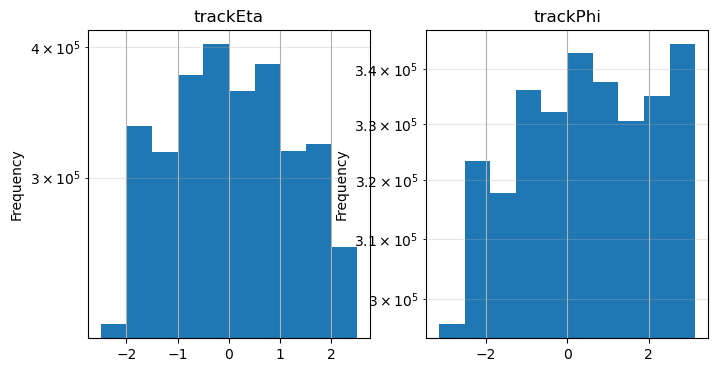

,trackEta,trackPhi
count,"3,295,697.0000","3,295,697.0000"
mean,0.0212,0.0603
std,1.3341,1.7995
min,-2.4996,-3.1415
0%,-2.4996,-3.1415
...,...,...
50%,-0.0027,0.0770
75%,1.1059,1.6177
90%,1.8729,2.5388
100%,2.4992,3.1409


In [30]:
analysis_cols = [
    "trackEta",
    "trackPhi",
]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="hist")
sms

#### Impact parameters

trackD0 has 14432 unique values:
 [-33.42454  -27.015762 -22.43061  ...  33.276596  35.0804          nan]
trackZ0 has 14429 unique values:
 [-192.57056 -190.19978 -188.10837 ...  158.52037  165.8586         nan]


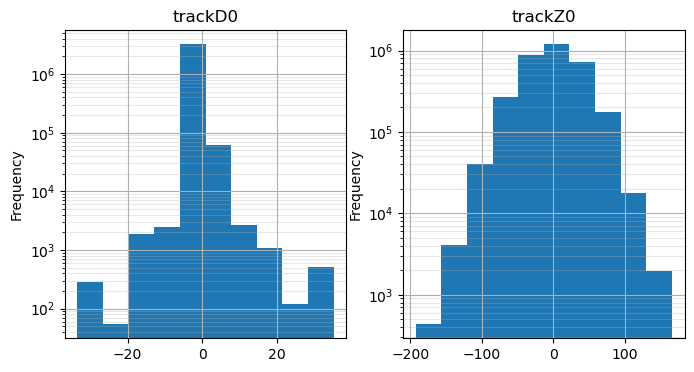

,trackD0,trackZ0
count,"3,295,697.0000","3,295,697.0000"
mean,0.0068,0.0286
std,0.9975,37.8023
min,-33.4245,-192.5706
0%,-33.4245,-192.5706
...,...,...
50%,0.0009,0.4046
75%,0.0121,25.3034
90%,0.0301,47.8855
100%,35.0804,165.8586


In [31]:
analysis_cols = [
    "trackD0",
    "trackZ0",
]
sms, unique_vals = explore_vars_distribution(events, analysis_cols, plot_type="hist")
sms

#### Plots

In [32]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 8))

# for i, c in enumerate(track_df.columns[1:4]):
#     _ = track_df[c].hist(bins=22, ax=axes[i], log=True)
#     axes[i].set_title(f"{c} full distribution")
# #     plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(10, 8))
# for i, c in enumerate(track_df.columns[4:6]):
#     _ = track_df[c].hist(bins=22, ax=axes[i])
#     axes[i].set_title(f"{c} full distribution")
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(10, 8))
# for i, c in enumerate(track_df.columns[6:]):
#     _ = track_df[c].hist(bins=22, ax=axes[i], log=True)
#     axes[i].set_title(f"{c} full distribution")
# plt.show()

In [33]:
# outliers? --> it doesn't seem like so
# track_df[track_df.trackD0 < -50]

In [34]:
# track_df.trackD0[(track_df.trackD0 > -0.1)
#                  & (track_df.trackD0 < .1)].hist(bins=50)

In [35]:
# track_df.trackZ0[(track_df.trackZ0 > -100)
#                  & (track_df.trackZ0 < 100)].hist(bins=50)

<div class="alert alert-block alert-info">
    
D0 refers to distance from PV in $\phi$ plane projection (vertical, above/below beam). This is narrower since it depends on how well I can squeeze the particles with my EM field (kind of resolution).
    
Z0 refers to distance from PV in $\eta$ plane projection (longitudinal, forward/backward). This is wider since I can't control where two particles will cross along the beam pipe.
    

</div>

### cluster observables

In [36]:
events.head(15)

nTruthPart  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex               
2001         213           1.0000                     1.0000                                5   
                           NaN                        1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
                                                      1.0000                                5   
             211           NaN                        NaN                                   5   
             111           NaN                        NaN                                   5   
             22            NaN                        NaN                                   5   
                                                      NaN                                   5   
2006        -213           3.0000                     3.0000                                5   
                           4.0000                     3.0000                                5   
                           NaN                        3.0000                                5   
                                                      3.0000                                5   

                                                                                   truthPartStatus  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex                    
2001         213           1.0000                     1.0000                                     2   
                           NaN                        1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
                                                      1.0000                                     2   
             211           NaN                        NaN                                        1   
             111           NaN                        NaN                                        2   
             22            NaN                        NaN                                        1   
                                                      NaN                                        1   
2006        -213           3.0000                     3.0000                                     2   
                           4.0000                     3.0000                                     2   
                           NaN                        3.0000                                     2   
                                                      3.0000                                     2   

                                                                                   truthPartPt  \
eventNumber truthPartPdgId cluster_fullHitsTruthIndex cluster_cell_hitsTruthIndex                
2001         213           1.0000                     1.0000                            2.5714   
                           NaN                        1.0000                            2.5714   
                                                      1.0000                            2.5714   
                                                      1.0000                            2.5714   
                                                      1.0000                            2.5714   
            

cluster_Pt has 17014 unique values:
 [2.0573882e-04 1.0081406e-03 1.0875987e-03 ... 1.8425468e+03 1.8624427e+03
           nan]
cluster_E has 17012 unique values:
 [2.2053432e-04 1.0108795e-03 1.1161104e-03 ... 1.9016157e+03 1.9344324e+03
           nan]
cluster_E_LCCalib has 17012 unique values:
 [2.2053432e-04 1.0108795e-03 1.1161104e-03 ... 2.1900864e+03 2.1903220e+03
           nan]


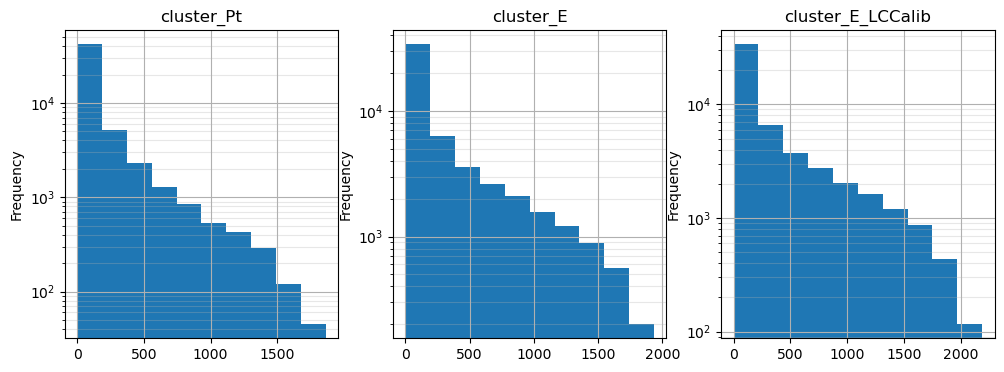

,cluster_Pt,cluster_E,cluster_E_LCCalib
count,"52,971.0000","52,971.0000","52,971.0000"
mean,137.0518,269.9985,302.1477
std,250.2314,391.1873,428.3395
min,0.0002,0.0002,0.0002
0%,0.0002,0.0002,0.0002
...,...,...,...
50%,30.8612,76.6543,91.6914
75%,146.0198,366.2325,415.7130
90%,406.0999,879.6910,970.6458
100%,"1,862.4427","1,934.4324","2,190.3220"


In [37]:
cluster_df = events.reset_index().drop_duplicates(["eventNumber", "cluster_fullHitsTruthIndex"])

analysis_cols = ["cluster_Pt", "cluster_E", "cluster_E_LCCalib"]
sms, unique_vals = explore_vars_distribution(cluster_df, analysis_cols, plot_type="hist")
sms

#### Angular distributions


cluster_Eta has 17010 unique values:
 [-2.999676  -2.9974055 -2.9972308 ...  2.992442   2.9954426        nan]
cluster_Phi has 17010 unique values:
 [-3.140207  -3.1389856 -3.1385658 ...  3.1403565  3.1412349        nan]


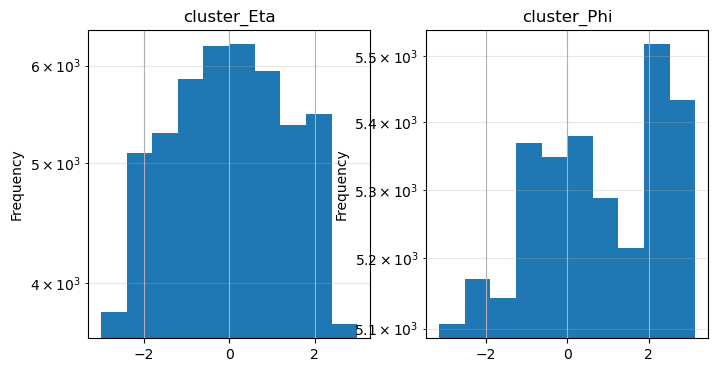

,cluster_Eta,cluster_Phi
count,"52,971.0000","52,971.0000"
mean,0.0165,0.0342
std,1.6015,1.8124
min,-2.9997,-3.1402
0%,-2.9997,-3.1402
...,...,...
50%,0.0257,0.0384
75%,1.3406,1.6125
90%,2.2174,2.5252
100%,2.9954,3.1412


In [38]:
analysis_cols = [
    "cluster_Eta",
    "cluster_Phi",
]
sms, unique_vals = explore_vars_distribution(cluster_df, analysis_cols, plot_type="hist")
sms

cluster_EM_PROBABILITY has 3176 unique values:
 [0.0000000e+00 7.3339138e-06 7.4025402e-06 ... 9.9961585e-01 1.0000000e+00
           nan]


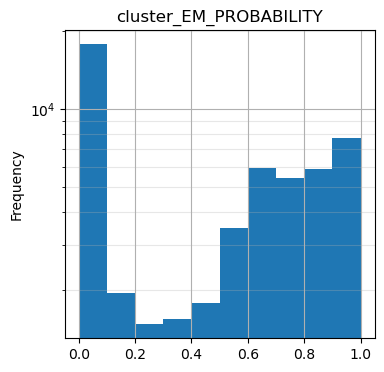

,cluster_EM_PROBABILITY
count,"52,971.0000"
mean,0.4624
std,0.3732
min,0.0000
0%,0.0000
...,...
50%,0.5723
75%,0.8097
90%,0.9387
100%,1.0000


In [41]:
analysis_cols = [
    'cluster_EM_PROBABILITY',
]

sms, unique_vals = explore_vars_distribution(cluster_df, analysis_cols, plot_type="hist")
sms

cluster_cell_ID has 54877 unique values:
 [7.40294656e+08 7.40294658e+08 7.40294660e+08 ... 1.28449208e+09
 1.28449259e+09            nan]
cluster_cell_E has 11061 unique values:
 [5.0299922e-03 5.0300714e-03 5.0300821e-03 ... 1.1071597e+03 1.3283638e+03
           nan]


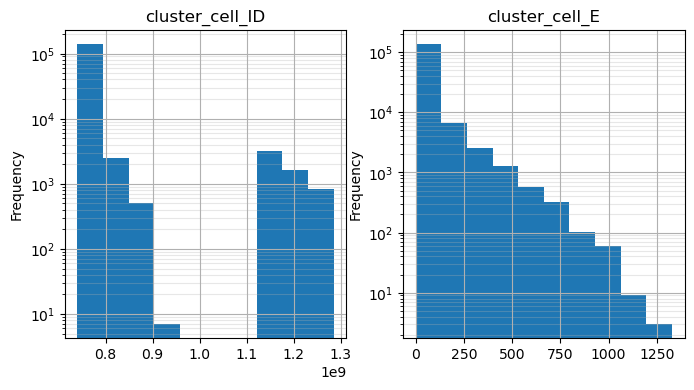

,cluster_cell_ID,cluster_cell_E
count,"148,170.0000","148,170.0000"
mean,"780,809,881.8574",36.2980
std,"82,689,300.3670",90.3333
min,"740,294,656.0000",0.0050
0%,"740,294,656.0000",0.0050
...,...,...
50%,"765,668,918.0000",4.3900
75%,"776,209,476.0000",24.4618
90%,"782,237,782.0000",99.1516
100%,"1,284,492,592.0000","1,328.3638"


In [40]:
cluster_cell_df = events.reset_index().drop_duplicates(["eventNumber", "cluster_fullHitsTruthIndex", "cluster_cell_hitsTruthIndex"])

analysis_cols = [
    'cluster_cell_ID',
    'cluster_cell_E',
]

sms, unique_vals = explore_vars_distribution(cluster_cell_df, analysis_cols, plot_type="hist")
sms

cluster_cell_hitsE_Invisible has 54902 unique values:
 [-4.0562499e-02 -3.3875000e-02 -2.9017579e-02 ...  4.1157001e+01
  4.3528000e+01            nan]
cluster_cell_hitsE_Escaped has 2372 unique values:
 [0.0000000e+00 1.0595703e-04 1.0827637e-04 ... 1.4384000e+01 1.5376000e+01
           nan]


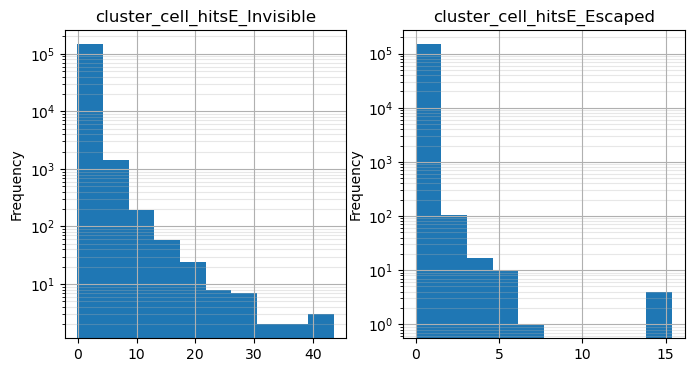

(       cluster_cell_hitsE_Invisible  cluster_cell_hitsE_Escaped
 count                  148,170.0000                148,170.0000
 mean                         0.3373                      0.0197
 std                          1.0280                      0.1342
 min                         -0.0406                      0.0000
 0%                          -0.0406                      0.0000
 10%                          0.0000                      0.0000
 25%                          0.0000                      0.0000
 50%                          0.0175                      0.0000
 75%                          0.2137                      0.0000
 90%                          0.8951                      0.0000
 100%                        43.5280                     15.3760
 max                         43.5280                     15.3760,
 {'cluster_cell_hitsE_Invisible': array([-4.0562499e-02, -3.3875000e-02, -2.9017579e-02, ...,
          4.1157001e+01,  4.3528000e+01,            nan], dt

In [42]:
analysis_cols = [
    'cluster_cell_hitsE_Invisible',
    'cluster_cell_hitsE_Escaped',
]

sms, unique_vals = explore_vars_distribution(cluster_cell_df, analysis_cols, "hist")
sms

cluster_cell_hitsE_EM has 62696 unique values:
 [0.0000000e+00 3.8261414e-06 4.7302246e-06 ... 1.0352000e+03 1.2281006e+03
           nan]
cluster_cell_hitsE_nonEM has 64123 unique values:
 [0.0000000e+00 1.5050173e-08 4.4286249e-08 ... 1.5811200e+02 1.7793600e+02
           nan]


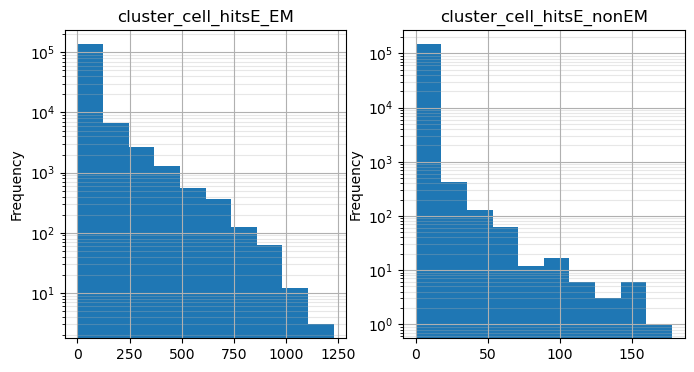

In [43]:
analysis_cols = [
    'cluster_cell_hitsE_EM',
    'cluster_cell_hitsE_nonEM',
]

sms, unique_vals = explore_vars_distribution(cluster_cell_df, analysis_cols, "hist")

In [45]:
cluster_df[cluster_df.cluster_fullHitsTruthIndex.isnull()]

,eventNumber,truthPartPdgId,cluster_fullHitsTruthIndex,cluster_cell_hitsTruthIndex,nTruthPart,truthPartStatus,truthPartPt,truthPartE,truthPartMass,truthPartEta,truthPartPhi,nTrack,trackPt,trackP,trackMass,trackEta,trackPhi,trackTruthParticleIndex,trackVisibleCalHitCaloEnergy,trackFullCalHitCaloEnergy,trackSubtractedCaloEnergy,trackD0,trackZ0,nCluster,cluster_E,cluster_E_LCCalib,cluster_Pt,cluster_Eta,cluster_Phi,cluster_nCells,cluster_EM_PROBABILITY,cluster_cell_ID,cluster_cell_E,cluster_cell_hitsE_EM,cluster_cell_hitsE_nonEM,cluster_cell_hitsE_Invisible,cluster_cell_hitsE_Escaped,cluster_fullHitsTruthE,cluster_visibleHitsTruthIndex,cluster_visibleHitsTruthE,cluster_cell_hitsTruthE
1,2001,213,NaN,1.0000,5,2,2.5714,6.7463,2.8231,1.5142,2.5839,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.3803,1.2512,0.2610,0.9233,2.0177,16.0000,0.0256,"769,664,164.0000",0.1747,0.1271,0.0008,-0.0000,0.0000,NaN,NaN,NaN,127.9009
13,2006,-213,NaN,3.0000,5,2,5.0219,14.6175,2.0808,-1.7197,-1.7833,1,1.5815,5.1076,0.1396,-1.8406,-1.1950,1.0000,1.9292,2.8541,"1,458.0000",-0.0337,-13.8929,2,4.7547,13.1019,1.8501,-1.5968,-2.0150,48.0000,0.4056,"751,045,980.0000",0.0772,0.0632,0.0019,-0.0000,0.0000,NaN,NaN,NaN,65.0576
66,2009,213,NaN,3.0000,5,2,30.2001,75.4712,2.9907,1.5655,-1.2393,1,22.6757,57.3905,0.1396,1.5802,-1.1829,1.0000,33.4848,40.1393,"36,113.0000",0.0330,-10.8330,4,36.1139,58.2592,14.1657,1.5881,-1.2018,195.0000,0.0063,"776,210,846.0000",1.8689,0.9329,0.6781,0.3644,0.0000,NaN,NaN,NaN,3.7311
256,2010,-213,NaN,4.0000,5,2,19.0636,45.8303,0.7510,-1.5238,0.0794,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,18.5469,32.8505,7.5422,-1.5488,0.1231,93.0000,0.0082,"751,044,104.0000",0.3163,0.2332,0.0071,0.0222,0.0000,NaN,NaN,NaN,12.9922
378,2012,-213,NaN,NaN,5,2,1.3169,8.3309,0.8860,-2.5258,2.5057,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5197764,646589,213,NaN,1.0000,5,2,260.8163,"1,628.5676",3.5513,2.5183,-1.1038,1,11.8896,71.3570,0.1396,2.4782,-1.1525,1.0000,34.6025,45.4027,0.0000,0.0226,-22.9898,1,"1,072.4358","1,245.0673",168.6497,2.5368,-1.0991,214.0000,0.4783,"776,230,304.0000",3.0111,3.5311,0.2859,0.0676,0.0000,NaN,NaN,NaN,593.9688
5198344,646798,-213,NaN,NaN,5,2,6.5529,63.0189,2.9164,2.9529,-0.5762,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5198350,646797,213,NaN,1.0000,5,2,5.1556,19.2303,3.3254,1.9753,1.5330,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,9.3604,17.4477,2.2438,2.1068,1.6962,54.0000,0.1972,"776,221,832.0000",1.5205,1.3386,0.0618,-0.0000,0.0000,NaN,NaN,NaN,"1,400.4539"
5198421,646795,213,NaN,4.0000,5,2,9.1934,29.4644,2.4022,-1.8291,1.4403,1,3.3496,8.3355,0.1396,-1.5618,1.6906,1.0000,1.0999,1.3124,"1,438.0000",-0.0343,12.7069,2,19.3857,24.4908,5.5369,-1.9252,1.3097,63.0000,0.8947,"751,052,394.0000",2.4483,2.4381,0.0321,0.0001,0.0000,NaN,NaN,NaN,0.6338


cluster_fullHitsTruthIndex has 8 unique values:
 [ 1.  2.  3.  4.  5.  6.  7. nan]
cluster_visibleHitsTruthIndex has 8 unique values:
 [ 1.  2.  3.  4.  5.  6.  7. nan]
cluster_cell_hitsTruthIndex has 7 unique values:
 [ 1.  2.  3.  4.  5.  6. nan]


ValueError: Categorical categories cannot be null

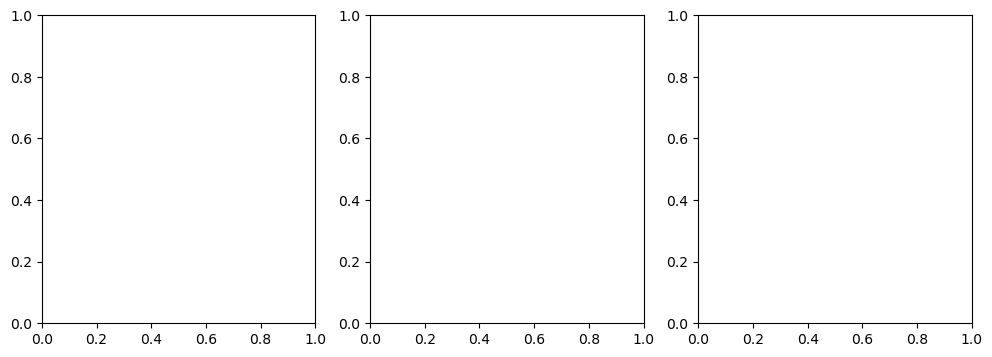

In [49]:
analysis_cols = [
    'cluster_fullHitsTruthIndex',
    'cluster_visibleHitsTruthIndex',
    'cluster_cell_hitsTruthIndex',  # same as fullHitsTruthIndex
]

sms, unique_vals = explore_vars_distribution(cluster_cell_df, analysis_cols, "bar")
sms

cluster_fullHitsTruthE has 47112 unique values:
 [-4.1722041e-03 -1.1603775e-03 -1.3783264e-04 ...  1.8076741e+03
  1.8286550e+03            nan]
cluster_visibleHitsTruthE has 47089 unique values:
 [0.0000000e+00 1.0478497e-07 1.2004375e-07 ... 1.8047501e+03 1.8262174e+03
           nan]
cluster_cell_hitsTruthE has 129539 unique values:
 [-8.8931274e+00 -6.0502014e+00 -5.8605042e+00 ...  9.0054650e+05
  9.9121100e+05            nan]


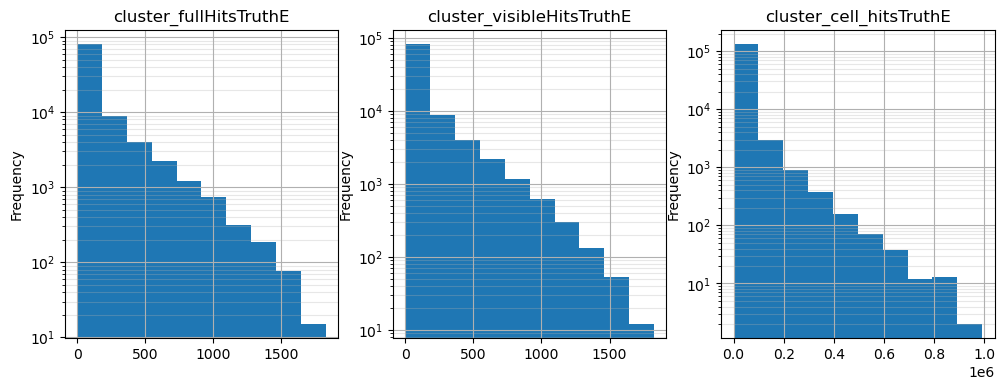

(       cluster_fullHitsTruthE  cluster_visibleHitsTruthE  \
 count             98,374.0000                98,374.0000   
 mean                 106.8344                   103.1457   
 std                  200.9660                   193.4627   
 min                   -0.0042                     0.0000   
 0%                    -0.0042                     0.0000   
 10%                    0.0558                     0.0507   
 25%                    1.7741                     1.6803   
 50%                   19.4761                    18.8521   
 75%                  111.9944                   108.3452   
 90%                  331.7207                   323.2127   
 100%               1,828.6550                 1,826.2174   
 max                1,828.6550                 1,826.2174   
 
        cluster_cell_hitsTruthE  
 count             136,114.0000  
 mean               13,351.8418  
 std                43,058.9180  
 min                    -8.8931  
 0%                     -8.8931  
 

In [48]:
analysis_cols = [
    'cluster_fullHitsTruthE', 'cluster_visibleHitsTruthE',
    'cluster_cell_hitsTruthE'
]

sms = explore_vars_distribution(cluster_cell_df, analysis_cols, "hist")
sms

<div class="alert alert-block alert-info">
    
**List of possible cluster variables to explore:**

    all_cluster_vars = [
        'cluster_E',
        'cluster_E_LCCalib',
        'cluster_Pt',
        'cluster_Eta',
        'cluster_Phi',
        'cluster_nCells',
    #     'cluster_ENG_CALIB_TOT', # always -1
    #     'cluster_ENG_CALIB_OUT_T', # always -1
    #     'cluster_ENG_CALIB_DEAD_TOT', # always -1
        'cluster_EM_PROBABILITY',
        #  'cluster_HAD_WEIGHT', # not interesting?
        #  'cluster_OOC_WEIGHT', # not interesting?
        #  'cluster_DM_WEIGHT', # not interesting?
        #  'cluster_CENTER_MAG', # not interesting?
        #  'cluster_FIRST_ENG_DENS', # not interesting?
        #  'cluster_CENTER_LAMBDA', # not interesting?
        #  'cluster_ISOLATION', # not interesting?
        #  'cluster_ENERGY_DigiHSTruth', # not interesting?
        'cluster_cell_ID',
        'cluster_cell_E',
        'cluster_cell_hitsE_EM',
        'cluster_cell_hitsE_nonEM',
        'cluster_cell_hitsE_Invisible',
        'cluster_cell_hitsE_Escaped',
        'cluster_fullHitsTruthIndex',
        'cluster_fullHitsTruthE',
    #     'cluster_visibleHitsTruthIndex', # same as fullHitsTruthIndex
        'cluster_visibleHitsTruthE',
        'cluster_cell_hitsTruthIndex', 
        'cluster_cell_hitsTruthE'
    ]
    
</div>

## High-level comparison (TO-DO)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

_ = events.truthPartEta.hist(bins=np.arange(-6, 6, 6 / 30), ax=ax[0])
ax[0].set_title("truthPartEta")
_ = events.trackEta.hist(bins=np.arange(-3, 3, 6 / 30),
                           ax=ax[1],
                           color="orange")
ax[1].set_title("trackEta")
_ = events.clusterEta.hist(bins=np.arange(-1, 1, 6 / 30),
                               ax=ax[2],
                               color="forestgreen")
ax[2].set_title("cluster_Eta")